In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 7, 0, 6, 5, 2, 7, 8])


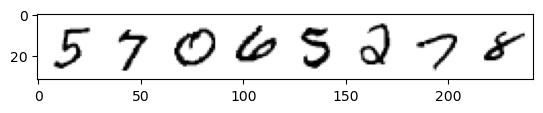

In [3]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")


def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

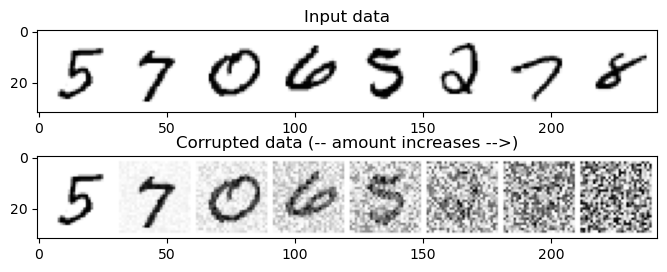

In [4]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(8, 3))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [5]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

Finished epoch 0. Average loss for this epoch: 0.027856
Finished epoch 1. Average loss for this epoch: 0.020934
Finished epoch 2. Average loss for this epoch: 0.019307
Finished epoch 3. Average loss for this epoch: 0.018256
Finished epoch 4. Average loss for this epoch: 0.017798


(0.0, 0.1)

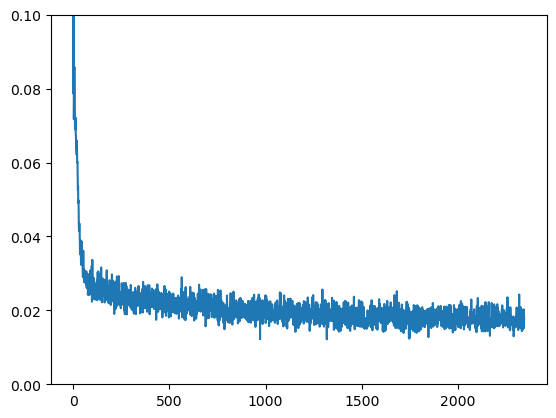

In [6]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 5

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in tqdm.trange(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

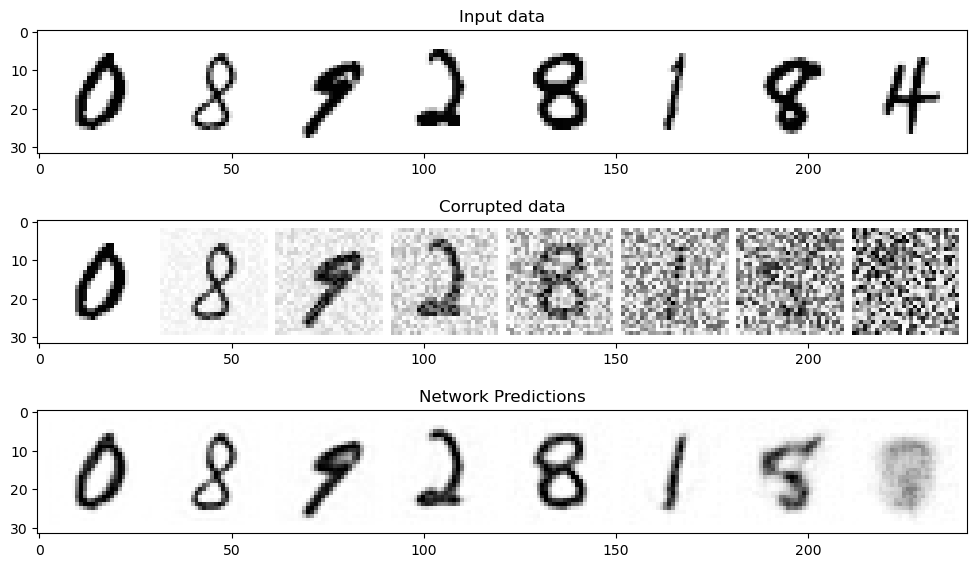

In [7]:
# @markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

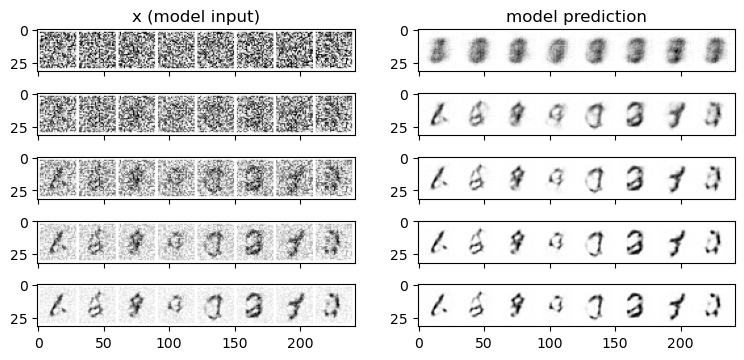

In [8]:
# @markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

In [9]:
# Ok la nostra implementazione toy con BasicUNet
# Adesso utilizziamo UNet2DModel usata da DDPM --> ottimizzata per modelli generativi rispetto alla BasicUNet
# principale differenza --> prediciamo il noise e non la denoised image
# altra differenza --> il modello è condizionato dalla quantità di noise presente via timestep conditioning
# si aggiunge rumore tramite timesteps scheduler, e non random noise amounts
# è necessaria una normalizzazione dei dati poichè DDPM add noise da una Gaussiana, e non un torch.rand

## UNet2DModel usata da DDPM

In [5]:
# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)  # <<<
net.to(device)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [6]:
# @markdown Trying UNet2DModel instead of BasicUNet:
import tqdm 

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 8

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in tqdm.trange(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample  # <<< Using timestep 0 always, adding .sample
        # pred = net(noisy_x, noise_amount*1000, return_dict=False)[0]

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")





 12%|█▎        | 1/8 [00:25<03:01, 25.95s/it]

Finished epoch 0. Average loss for this epoch: 0.019199


 25%|██▌       | 2/8 [00:51<02:33, 25.54s/it]

Finished epoch 1. Average loss for this epoch: 0.012811


 38%|███▊      | 3/8 [01:16<02:07, 25.53s/it]

Finished epoch 2. Average loss for this epoch: 0.011596


 50%|█████     | 4/8 [01:42<01:42, 25.51s/it]

Finished epoch 3. Average loss for this epoch: 0.011150


 62%|██████▎   | 5/8 [02:07<01:16, 25.50s/it]

Finished epoch 4. Average loss for this epoch: 0.010746


 75%|███████▌  | 6/8 [02:33<00:51, 25.50s/it]

Finished epoch 5. Average loss for this epoch: 0.010475


 88%|████████▊ | 7/8 [02:58<00:25, 25.46s/it]

Finished epoch 6. Average loss for this epoch: 0.010311


100%|██████████| 8/8 [03:24<00:00, 25.51s/it]

Finished epoch 7. Average loss for this epoch: 0.010092


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 75.28it/s]


Text(0.5, 1.0, 'Generated Samples')

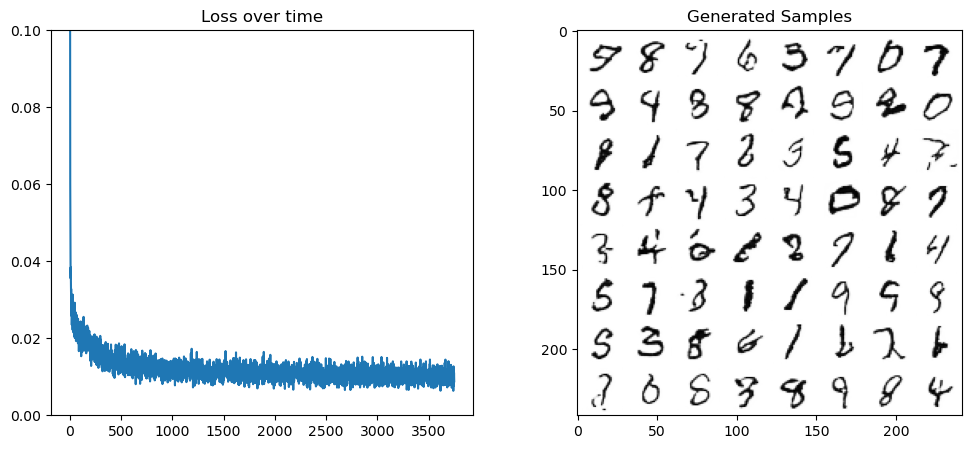

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in tqdm.trange(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")

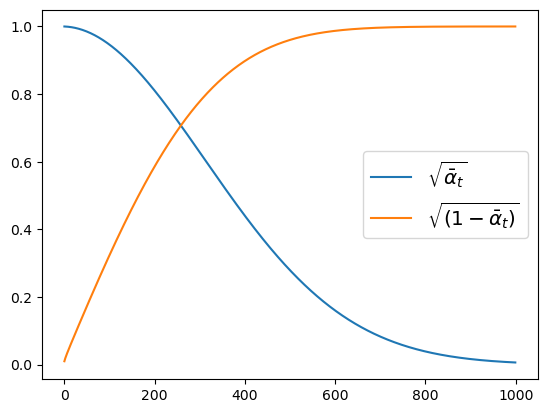

In [8]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


Text(0.5, 1.0, 'Noisy X')

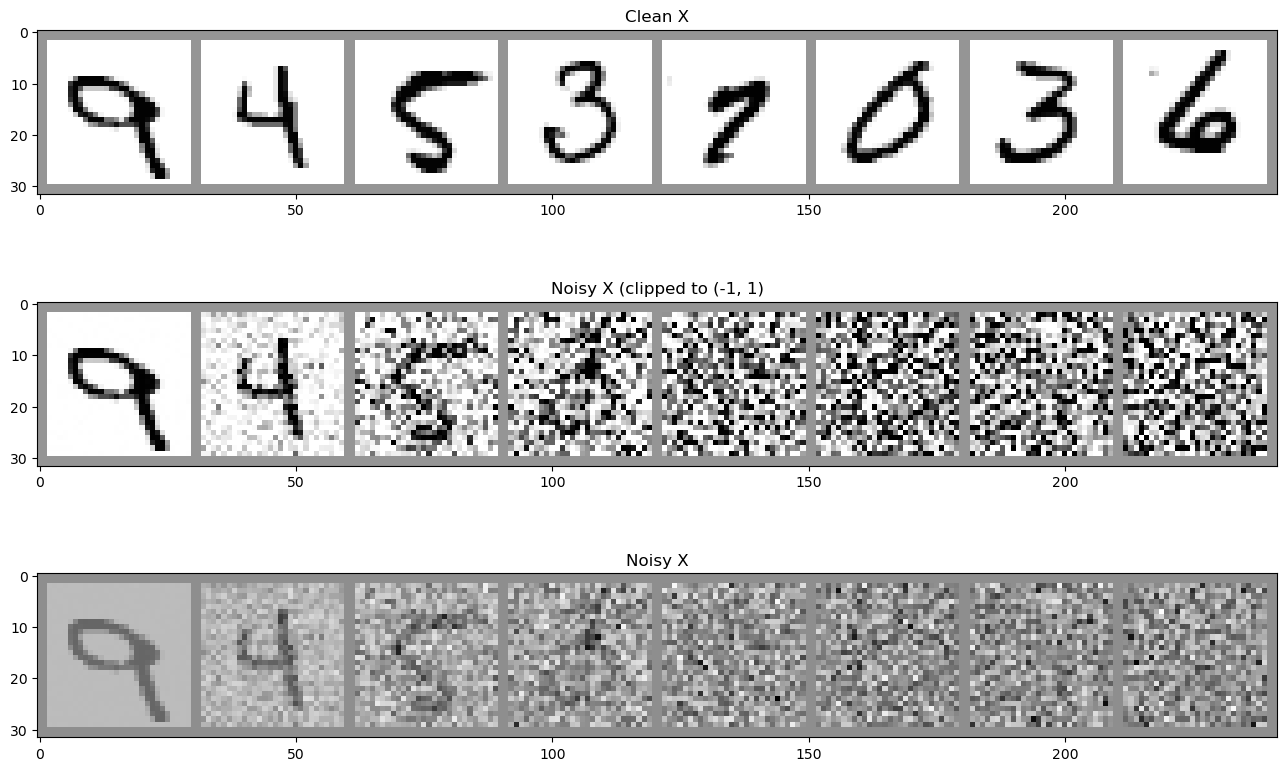

In [9]:
# @markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2.0 - 1.0  # Map to (-1, 1)
print("X shape", xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap="Greys")
axs[0].set_title("Clean X")

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)  # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1), cmap="Greys")
axs[1].set_title("Noisy X (clipped to (-1, 1)")
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap="Greys")
axs[2].set_title("Noisy X")